In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Cellular_plots_model:

    def __init__(self, n_steps, n_types, n_cells, nx=40, T=1, k=0.5, lamda=5, equilibrium_area=20):

        self.n_steps = n_steps
        self.n_types = n_types
        self.n_cells = n_cells

        self.nx = nx
        self.T = T
        self.k = k
        self.lamda = lamda
        self.equilibrium_area = equilibrium_area

        self.initialize_grid()

        self.step = 0
        self.hamiltonian = self.calc_hamoltonian(self.grid)

    def initialize_grid(self):
        
        # Cells are stored on a 3D grid, where the first two dimensions are spatial
        # and the third dimension stores the cell ID and type
        self.grid = np.zeros((self.nx + 2, self.nx + 2, 2))

        for cell in range(1, self.n_cells + 1):

            # Pick a random latice site which is not yet occupied
            while True:

                # Pick random lattice site
                i, j = np.random.randint(1, self.nx, 2)

                if self.grid[i, j, 0] == 0:
                    break
                
            cell_type = np.random.choice(np.arange(1, self.n_types))
            self.grid[i, j, 0] = cell
            self.grid[i, j, 1] = cell_type
            
    def run(self):
        
        while self.step < self.n_steps:
            self.update()

            if self.step % 100 == 0:
                print(f"Step: {self.step}", end="\r")
    
    def update(self):

        # Pick random lattice site
        i, j = np.random.randint(1, self.nx, 2)

        # Pick a random neighbour
        von_neumann_neighbourhood = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j-1)]
        von_neumann_index = np.random.randint(0, len(von_neumann_neighbourhood))
        neighbour_i, neighbour_j = von_neumann_neighbourhood[von_neumann_index]

        neighbour_ID = self.grid[neighbour_i, neighbour_j, 0]
        neighbour_type = self.grid[neighbour_i, neighbour_j, 1]

        grid_copy = self.grid.copy()
        grid_copy[i, j, 0] = neighbour_ID
        grid_copy[i, j, 1] = neighbour_type

        # Calculate new hamiltonian 
        new_hamiltonian = self.calc_hamoltonian(grid_copy)

        delta_hamiltonian = new_hamiltonian - self.hamiltonian

        if delta_hamiltonian < 0 or np.random.uniform() < np.exp(-delta_hamiltonian/(self.k * self.T)):
            
            # Update grid
            self.grid[i, j, 0] = neighbour_ID
            self.grid[i, j, 1] = neighbour_type
            self.hamiltonian = self.calc_hamoltonian(self.grid)

        self.step += 1

    def calc_hamoltonian(self, grid):

        H_vol = self.calc_hamoltonian_vol(grid)
        H_bond = self.calc_hamoltonian_bond(grid)

        return H_vol + H_bond
      
    def calc_hamoltonian_vol(self, grid):

        sigma = 0
        for cell_ID in range(1, self.n_cells + 1):

            cell_area = np.count_nonzero(self.grid[1: -1, 1:-1, 0] == cell_ID)
            sigma += (cell_area - self.equilibrium_area) ** 2

        return self.lamda * sigma

    def calc_hamoltonian_bond(self, grid):

        H_bond = 0
        for i in range(1, self.nx):
            for j in range(1, self.nx):

                H_bond += self.calc_hamoltonian_bond_local(grid, i, j)

        return H_bond

    def calc_hamoltonian_bond_local(self, grid, i, j):

        H_bond = 0
        cell_ID = grid[i, j, 0]
        cell_type = grid[i, j, 1]
        
        for i_offset in [-1, 0, 1]:
            for j_offset in [-1, 0, 1]:

                if i_offset == 0 and j_offset == 0:
                    continue
                    
                i_prime = i + i_offset
                j_prime = j + j_offset

                cell_prime_ID = grid[i, j, 0]
                cell_prime_type = grid[i_prime, j_prime, 1]

                J = self.J(cell_type, cell_prime_type)
                kronecker_delta = self.kronecker_delta(cell_ID, cell_prime_ID)

                H_bond += J * (1 - kronecker_delta)

        return H_bond
    
    def J(self, type1, type2):

        if type1 == 0 or type2 == 0:
            return 0

        if type1 == type2:
            return 1

        return -1

    def kronecker_delta(self, value1, value2):

        if value1 == value2:
            return 1

        return 0
            
    def show_grid(self):

        grid = self.grid.copy()

        # For plotting purposes set M cells to None
        grid[grid==0] = None
        
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.matshow(grid[1:-1, 1:-1, 0], cmap='hsv')
        ax1.set_title("Cell IDs")

        ax2.matshow(grid[1:-1, 1:-1, 1], cmap="hsv")
        ax2.set_title("Cell types")

        plt.tight_layout()
        plt.show()

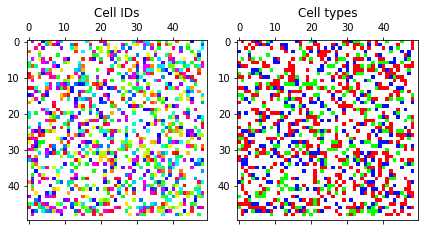

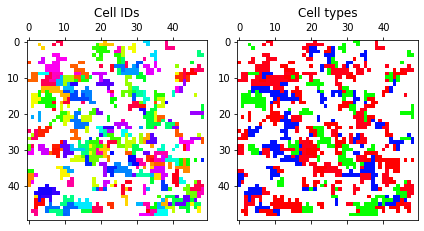

In [3]:
model = Cellular_plots_model(n_steps=10000, n_types=5, n_cells=1000, nx=50)
model.show_grid()
model.run()
model.show_grid()